In [63]:
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import random
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
NUM_CLASSES = 102

num_episodes = 500         # Number of episodes to train
n_way = 10                   # Number of classes per episode
k_shot = 5                  # Number of support examples per class
q_query = 5                 # Number of query examples per class


In [66]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [67]:
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

In [68]:

class EmbeddingNet(nn.Module):
    def __init__(self, output_dim=102):
        super(EmbeddingNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # remove final FC layer
        self.fc = nn.Linear(resnet.fc.in_features, output_dim)  # add new FC layer for embeddings

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)

# Define Prototypical Network
class PrototypicalNetwork(nn.Module):
    def __init__(self, embedding_net):
        super(PrototypicalNetwork, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, support_images, support_labels, query_images):
        # Compute embeddings for support and query images
        support_embeddings = self.embedding_net(support_images)
        query_embeddings = self.embedding_net(query_images)

        # Compute class prototypes by averaging embeddings of support images per class
        prototypes = []
        for class_id in torch.unique(support_labels):
            class_mask = support_labels == class_id
            class_embeddings = support_embeddings[class_mask]
            prototypes.append(class_embeddings.mean(0))
        prototypes = torch.stack(prototypes)

        # Calculate distances from each query embedding to each prototype
        distances = torch.cdist(query_embeddings, prototypes)
        return distances

In [69]:
embedding_net = EmbeddingNet().to(device)
proto_net = PrototypicalNetwork(embedding_net).to(device)
optimizer = optim.Adam(proto_net.parameters(), lr=0.001)

In [70]:
class EarlyStopper:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.counter = 0
        self.best_score = float('inf')
        self.verbose = verbose

    def early_stop(self, val_loss):
        if val_loss < self.best_score:
            self.best_score = val_loss
            self.counter = 0
        else:
            self.counter += 1
           
        if self.counter >= self.patience:
            if self.verbose:
                print("Early stopping...")
            return True
        return False

In [71]:
earlystopper = EarlyStopper()

In [72]:
def train(num_episodes, n_way, k_shot, q_query, optimizer, embedding_net, proto_net, earlystopper):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    for episode in range(num_episodes):
        # Randomly sample n-way classes for this episode
        episode_classes = random.sample(range(NUM_CLASSES), n_way)
        
        # Separate support and query sets for each class
        support_indices, query_indices = [], []
        for cls in episode_classes:
            # Find all indices of images belonging to this class
            class_indices = [i for i, label in enumerate(train_dataset._labels) if label == cls]
            random.shuffle(class_indices)
            
            # Take k_shot examples for support and q_query for query
            support_indices.extend(class_indices[:k_shot])
            query_indices.extend(class_indices[k_shot:k_shot + q_query])

        # Create support and query datasets
        support_set = Subset(train_dataset, support_indices)
        query_set = Subset(train_dataset, query_indices)
        support_loader = DataLoader(support_set, batch_size=k_shot * n_way, shuffle=False)
        query_loader = DataLoader(query_set, batch_size=q_query * n_way, shuffle=False)

        # Load support and query batches
        support_images, support_labels = next(iter(support_loader))
        query_images, query_labels = next(iter(query_loader))
        support_images = support_images.to(device)
        query_images = query_images.to(device)

        # Map support/query labels to 0–(n_way-1) range
        unique_labels = torch.unique(support_labels)
        label_map = {original.item(): mapped for mapped, original in enumerate(unique_labels)}
        mapped_support_labels = torch.tensor([label_map[label.item()] for label in support_labels]).to(device)
        mapped_query_labels = torch.tensor([label_map[label.item()] for label in query_labels]).to(device)

        # Forward pass
        distances = proto_net(support_images, mapped_support_labels, query_images)
        query_predictions = torch.argmin(distances, dim=1)

        # Calculate loss and accuracy
        loss = F.cross_entropy(-distances, mapped_query_labels)  # Negative distances used as logits
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = (query_predictions == mapped_query_labels).float().mean().item() * 100
        train_loss_history.append(loss.item())
        train_accuracy_history.append(accuracy)

        if (episode + 1) % 10 == 0:
            val_loss, val_accuracy = 0, 0
            val_episodes = 10  # Run validation over 10 episodes
            
            for _ in range(val_episodes):
                # Sample validation classes and data similarly as in training
                val_classes = random.sample(range(NUM_CLASSES), n_way)
                val_support_indices, val_query_indices = [], []
                for cls in val_classes:
                    class_indices = [i for i, label in enumerate(val_dataset._labels) if label == cls]
                    random.shuffle(class_indices)
                    val_support_indices.extend(class_indices[:k_shot])
                    val_query_indices.extend(class_indices[k_shot:k_shot + q_query])

                val_support_set = Subset(val_dataset, val_support_indices)
                val_query_set = Subset(val_dataset, val_query_indices)
                val_support_loader = DataLoader(val_support_set, batch_size=k_shot * n_way, shuffle=False)
                val_query_loader = DataLoader(val_query_set, batch_size=q_query * n_way, shuffle=False)

                val_support_images, val_support_labels = next(iter(val_support_loader))
                val_query_images, val_query_labels = next(iter(val_query_loader))
                val_support_images = val_support_images.to(device)
                val_query_images = val_query_images.to(device)
                
                # Map validation labels similarly
                val_label_map = {original.item(): mapped for mapped, original in enumerate(torch.unique(val_support_labels))}
                mapped_val_support_labels = torch.tensor([val_label_map[label.item()] for label in val_support_labels]).to(device)
                mapped_val_query_labels = torch.tensor([val_label_map[label.item()] for label in val_query_labels]).to(device)

                # Forward pass for validation
                val_distances = proto_net(val_support_images, mapped_val_support_labels, val_query_images)
                val_query_predictions = torch.argmin(val_distances, dim=1)
                val_loss += F.cross_entropy(-val_distances, mapped_val_query_labels).item()
                val_accuracy += (val_query_predictions == mapped_val_query_labels).float().mean().item() * 100

            # Average validation loss and accuracy
            val_loss /= val_episodes
            val_accuracy /= val_episodes
            val_loss_history.append(val_loss)
            val_accuracy_history.append(val_accuracy)
            
            print(f"Validation after episode {episode + 1}: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%")

            if earlystopper.early_stop(val_loss):
                break 
            
        print(f"Episode {episode + 1}/{num_episodes}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%")


    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

In [73]:
train_loss, train_accuracy, val_loss, val_accuracy = train(num_episodes, n_way, k_shot, q_query, optimizer, embedding_net, proto_net, earlystopper)

Episode 1/500, Loss: 2.1590, Accuracy: 82.00%
Episode 2/500, Loss: 1.7942, Accuracy: 84.00%
Episode 3/500, Loss: 1.8878, Accuracy: 72.00%
Episode 4/500, Loss: 1.6309, Accuracy: 82.00%
Episode 5/500, Loss: 1.6513, Accuracy: 72.00%
Episode 6/500, Loss: 1.7165, Accuracy: 62.00%
Episode 7/500, Loss: 1.7382, Accuracy: 64.00%
Episode 8/500, Loss: 1.6473, Accuracy: 74.00%
Episode 9/500, Loss: 1.6449, Accuracy: 72.00%
Validation after episode 10: Loss: 1.6700, Accuracy: 65.40%
Episode 10/500, Loss: 1.5875, Accuracy: 78.00%
Episode 11/500, Loss: 1.4811, Accuracy: 86.00%
Episode 12/500, Loss: 1.5846, Accuracy: 64.00%
Episode 13/500, Loss: 1.5762, Accuracy: 74.00%
Episode 14/500, Loss: 1.7940, Accuracy: 54.00%
Episode 15/500, Loss: 1.5439, Accuracy: 80.00%
Episode 16/500, Loss: 1.6819, Accuracy: 56.00%
Episode 17/500, Loss: 1.7560, Accuracy: 40.00%
Episode 18/500, Loss: 1.7545, Accuracy: 52.00%
Episode 19/500, Loss: 1.5993, Accuracy: 70.00%
Validation after episode 20: Loss: 1.7237, Accuracy: 62.

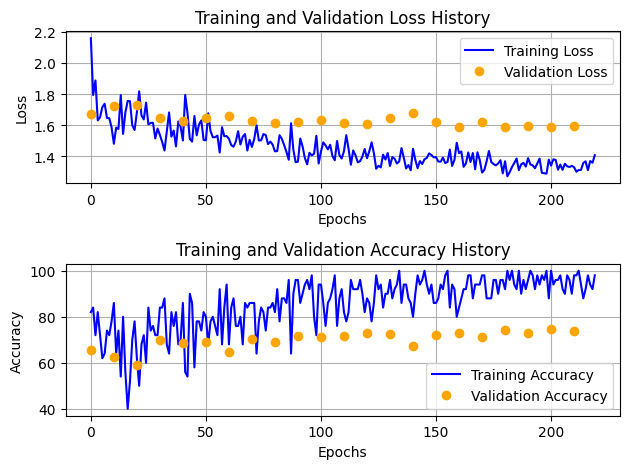

In [74]:
def plot_loss_and_accuracy(train_losses_history, train_accuracies_history, val_losses_history, val_accuracies_history):
    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(train_losses_history, label='Training Loss', color='blue')
    val_episodes = range(0, len(train_losses_history), 10)  # Marks every 10 episodes
    ax1.plot(val_episodes, val_losses_history, 'o', label='Validation Loss', color='orange')
    ax1.set_title('Training and Validation Loss History')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid()

    ax2.plot(train_accuracies_history, label='Training Accuracy', color='blue')
    val_episodes = range(0, len(train_accuracies_history), 10)  # Marks every 10 episodes
    ax2.plot(val_episodes, val_accuracies_history, 'o', label='Validation Accuracy', color='orange')
    ax2.set_title('Training and Validation Accuracy History')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid()

    plt.tight_layout() 
    plt.show()

    
plot_loss_and_accuracy(train_loss, train_accuracy, val_loss, val_accuracy)

In [75]:
def evaluate_few_shot_model(model, test_dataset, n_way=5, k_shot=5, q_query=5, num_episodes=100):
    model.eval()  # Set the model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_accuracy = 0
    
    with torch.no_grad():  # Disable gradient calculation
        for episode in range(num_episodes):
            # Sample n-way classes for the episode
            episode_classes = random.sample(range(NUM_CLASSES), n_way)
            
            support_indices, query_indices = [], []
            for cls in episode_classes:
                class_indices = [i for i, label in enumerate(test_dataset._labels) if label == cls]
                random.shuffle(class_indices)
                
                # Take k_shot examples for support and q_query for query
                support_indices.extend(class_indices[:k_shot])
                query_indices.extend(class_indices[k_shot:k_shot + q_query])

            # Create support and query sets
            support_set = Subset(test_dataset, support_indices)
            query_set = Subset(test_dataset, query_indices)
            support_loader = DataLoader(support_set, batch_size=k_shot * n_way, shuffle=False)
            query_loader = DataLoader(query_set, batch_size=q_query * n_way, shuffle=False)

            # Load support and query images
            support_images, support_labels = next(iter(support_loader))
            query_images, query_labels = next(iter(query_loader))
            support_images = support_images.to(device)
            query_images = query_images.to(device)

            # Map labels to a 0–(n_way-1) range
            unique_labels = torch.unique(support_labels)
            label_map = {original.item(): mapped for mapped, original in enumerate(unique_labels)}
            mapped_support_labels = torch.tensor([label_map[label.item()] for label in support_labels]).to(device)
            mapped_query_labels = torch.tensor([label_map[label.item()] for label in query_labels]).to(device)

            # Forward pass to get distances
            distances = model(support_images, mapped_support_labels, query_images)
            query_predictions = torch.argmin(distances, dim=1)

            # Calculate accuracy for this episode
            episode_accuracy = (query_predictions == mapped_query_labels).float().mean().item()
            total_accuracy += episode_accuracy

    accuracy = (total_accuracy / num_episodes) * 100
    return accuracy

test_accuracy = evaluate_few_shot_model(proto_net, test_dataset)
print(f"Test Set Accuracy: {test_accuracy:.2f}%")

Test Set Accuracy: 81.16%
